<a href="https://colab.research.google.com/github/oksk1111/self_machinelearning/blob/main/selfML_ch09_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_RNN_IMDB_%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 순차데이터 (Sequential data)
- 예: 텍스트, 시계열 데이터 (time series data)
- 이전 입력이 중요한 데이터
- Dense 나 Convolution 은 기억장치가 필요 없다. 순서가 중요치 않다. - 입력데이터의 흐름이 앞으로만 -> 피드포워드 신경망(feedforward neural network: FFNN)

# 순환 신경망 (Recurrent neuural network: RNN)
- 신경망이 이전에 처리했던 샘플을 다음 샘플을 처리하는데 재사용 - 순환 필요
- 모양은 Dense 와 비슷하나 이전 입력에 대한 출력을 다음 입력에 추가한다. 이래서 모양이 순환적으로 생김!!
- '이전 샘플에 대한 기억을 가지고 있다' - 타임스텝(timestep)
- 타입스텝이 오래될 수록 순환되는 정보는 희미해진다.
- RNN 에서 layer 를 셀(cell)이라 부른다.
- 셀의 출력 = 은닉상태(hidden state) 라고 부른다.
- 일반적으로 은닉층의 활성화함수로 tanh 를 많이 쓴다!

In [ ]:
# 문제: iMDB 리뷰데이터가 긍정인지 아닌지 확인.
#- 1은 긍정, 0은 부정 

from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)    # 해당 함수는 imdb 데이터를 가져오는 특화 함수이다. 가장 많이 등장하는 최빈도 500 개만 가져올 수 있다. 즉, 단어는 500개로 한정된다.

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# 데이터 확인
print(train_input.shape, test_input.shape)

# 첫번째 데이터 리뷰/타겟 확인
print(len(train_input[0]))    # 218개의 토큰. 영어의 경우 띄어쓰기 기준 단어
print(train_input[0])         # 단어가 정수로 변환된 상태
print(train_target[0])        # 리뷰가 긍정(1)인지 부정(0) 인지 파악. boolean 값.


(25000,) (25000,)
218
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1


In [ ]:
# 훈련세트에서 검증세트 분리
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

239.00925 178.0


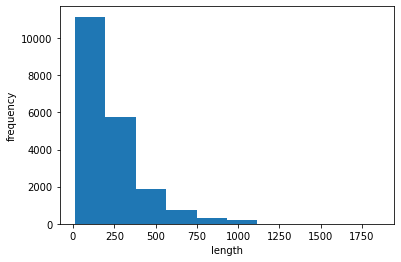

In [ ]:
# 각 리뷰 길이 확인
import numpy as np
lengths = np.array([len(x) for x in train_input])

# 전체 리뷰의 평균길이와 중간값 확인
print(np.mean(lengths), np.median(lengths))
#- 평균과 중간값의 차이가 큰 것으로 보아 데이터가 한쪽으로 치우친듯

# 길이 분포 확인 - 입력인 1차원배열의 2차원형태이며, 1차원레벨이 x축 분포로 그려진다.
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()


In [ ]:
# 데이터가 많이 치우쳐져 있으므로 100개 길이 미만의 데이터만 쓰기로 한다.
#- 100 길이 미만 데이터 중 100에 안 맞는 것은 0으로 패딩을 채우도록 한다.

from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)    # maxlen 으로 설정한값보다 긴건 잘라내고, 짧으면 0(패딩)으로 채운다.
#- 긴거 자를땐 앞부분을 자른다.
#-- 긴거 뒷부분을 자르고 싶으면 pad_sequences(truncating='post') 로 기입 (기본값은 'pre')

# 패딩 결과 확인
print(train_seq.shape)    # 샘플 20000, 토큰 100개

# 첫번째 데이터 확인
print(train_seq[0])

# 위 데이터에서 앞이 잘린건지 뒤가 잘린건지...
print(train_seq[0][-10:])   # 뒤가 출력되는것으로 보아 앞이 잘림...

# 패딩이 들어간 데이터 확인
print(train_seq[5])  

# 검증세트도 길이 100으로 처리
val_seq = pad_sequences(val_input, maxlen=100)

(20000, 100)
[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]
[  6   2  46   7  14  20  10  10 470 158]
[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [ ]:
# RNN 만들기
#- SimpleRNN 사용
#-- (뉴런개수, input_shape(샘플길이, 가능한단어개수)), 기본 activation 함수는 'tanh'
# 해당 문제는 0,1 을 찾는 문제이므로, 마지막 출력층은 1개의 뉴런, 활성화함수로 시그모이드 사용.

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))    # SimpleRNN(뉴런개수, input_shape=(100(샘플길이), 500(각토큰마다 500개짜리 원-핫인코딩(500개 단어만 가져왔으므로)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 정수 배열을 원-핫 인코딩으로 변경 to_categorical()
#- 인자에 들어가는 배열의 항목을 탐색해 가능한 범위의 항목의 개수(여기선 500개)를 모든 샘플에 추가한다.
train_oh = keras.utils.to_categorical(train_seq)    # (2000, 100) 크기의 배열을 정수마다 원-핫 인코딩으로 변형하여 (2000, 100, 500) 이 됨. 입력이 1차원 정수배열 (100,) 에서 (100, 500) 으로 변경
print(train_oh.shape)

# 원-핫 인코딩 변경된 것 확인
print(train_oh[0][0][:12])    # 한 샘플당 500개 이므로 12개 까지만 출력해본다.
print(np.sum(train_oh[0][0]))   # 원-핫이 맞는지 확인. 한샘플의 500개 항목을 모두 더했을때 1이 됨을 확인

val_oh = keras.utils.to_categorical(val_seq)    # 검증데이터도 똑같이 to_categorical() 수행

# 모델 확인
model.summary()
#- 4072 = 500(500차원 원-핫인코딩) * 8(뉴런개수) + (8 * 8)(은닉상태에서의 가중치) + 8(절편)
#- 9 = 8(입력) + 1(절편)

(20000, 100, 500)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 훈련
#- RMSprop 0.001 -> 0.0001 (왜?)
#- epoch=100 (왜?)
#- barch_size=64 (왜?)
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 54ms/step - loss: 0.6987 - accuracy: 0.5015 - val_loss: 0.6958 - val_accuracy: 0.5174
Epoch 2/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6943 - accuracy: 0.5148 - val_loss: 0.6930 - val_accuracy: 0.5268
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6914 - accuracy: 0.5227 - val_loss: 0.6918 - val_accuracy: 0.5196
Epoch 4/100
313/313 [==============================] - 11s 37ms/step - loss: 0.6891 - accuracy: 0.5325 - val_loss: 0.6899 - val_accuracy: 0.5294
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6849 - accuracy: 0.5537 - val_loss: 0.6810 - val_accuracy: 0.5716
Epoch 6/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6718 - accuracy: 0.6000 - val_loss: 0.6687 - val_accuracy: 0.6112
Epoch 7/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6561 - accuracy: 0.6354 - val_loss: 0.6523 - val_ac

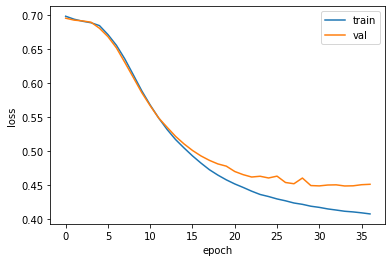

In [ ]:
# 검증 그래프 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# 원-핫 인코딩 방식의 문제 - 입력데이터가 엄청 커진다!!
print(train_seq.nbytes, train_oh.nbytes)    # 입력데이터가 원본의 500배로 커짐!!

#-> 입력데이터를 효율화 하기 위해 단어임베딩 기법 사용!!

8000000 4000000000


# 단어 임베딩 (Word embedding)
- 각 단어를 고정된 크기의 실수 벡터로 바꾸어 줌
- 장점: 입력으로 정수 데이터를 받는다. (위 데이터에서 tra_seq 사용 가능 - 원-핫인코딩에 비해 메모리 절약 가능), 원핫 인코딩 수행시의 비효율적인 데이터 개수(위 예에서 샘플당 500개) 대신 n개의 정수(=벡터)만 있으면 된다!
- 예: 'cat' [0.2, 0.1, 1.3, 0.8, 0.2, 0.4, 1.1, 0.9, 0.2, 0.1] # 다차원 벡터

In [ ]:
# Embedding layer 추가
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))   # 500(어휘사전크기), 16(임베딩벡터의 크기)(왜 16?), input_length=입력 시퀀스의 길이(샘플의 길이)
#- 8000 = 500 * 16    (500개의 각 토큰을 16인 벡터로 변경)
model2.add(keras.layers.SimpleRNN(8))
#- 200 = 16(앞층의출력) * 8(뉴런개수) + (8 * 8)(은닉상태에서의 가중치) + 8(절편)
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 워드임베딩 학습
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6956 - accuracy: 0.5015 - val_loss: 0.6928 - val_accuracy: 0.5168
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6891 - accuracy: 0.5319 - val_loss: 0.6887 - val_accuracy: 0.5326
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6820 - accuracy: 0.5695 - val_loss: 0.6808 - val_accuracy: 0.5754
Epoch 4/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6594 - accuracy: 0.6393 - val_loss: 0.6309 - val_accuracy: 0.6830
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 0.5975 - accuracy: 0.7135 - val_loss: 0.5844 - val_accuracy: 0.7184
Epoch 6/100
313/313 [==============================] - 6s 21ms/step - loss: 0.5608 - accuracy: 0.7405 - val_loss: 0.5561 - val_accuracy: 0.7426
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5388 - accuracy: 0.7565 - val_loss: 0.5345 - val_accuracy:

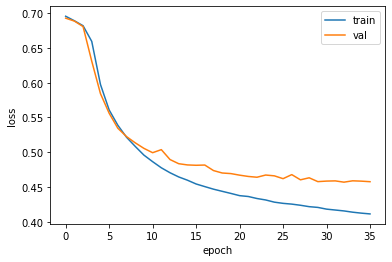

In [ ]:
# 훈련/검증 손실 그래프 출력
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# LSTM(Long Short-Term memory), GRU셀
- 일반적으로 기본 순환층(SimpleRNN)은 긴 시퀀스를 학습하기 어렵다.
- 시퀀스가 길수록 순환되는 은닉 상태에 담긴 저보가 점차 희석되기 때문.
- 이를 보완하기 위한 것이 LSTM(Long Short-Term memory), GRU셀

1. LSTM
- 총 4개의 셀이 존재

2. GRU
- 총 3개의 셀이 존재

![LSTM_GRU](https://www.researchgate.net/publication/344831339/figure/fig9/AS:949709535465489@1603439806333/The-indepenent-cells-of-RNN-LSTM-and-GRU.png)

In [1]:
# LSTM 신경망 훈련하기

# 데이터 가져오기
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
# 데이터 전처리
# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

# LSTM 포함한 model 만들기
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))   # 이게 추가!!
#- 800 = (16(앞층의출력) * 8(뉴런개수) + (8 * 8)(은닉상태에서의 가중치)) + 8(절편))4(LSTM 4개의 셀)
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(train_seq[:2])

[[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
    5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
   76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
    2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
    2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
    6   2  46   7  14  20  10  10 470 158]
 [206   2  26   2   5   2   4 414   9   2  60   4   2 461   2   2  33   4
   58   7  94   2   2  16 467   4   2   7   2   2   6 132  19   2   5   2
    2   2   2   2  18  14 282   2   2   2  56  14   2   2   2   2  17  48
   12  16   4   2  20   7  32  58   2  12  83  35   2   2   2   2   2 211
   28   2 475   2  75  70 168   2  12  17   6   2   2 206   2  19   6   2
  312   2   2   2   2   2   5   6   2   2]]


In [7]:
# 모델 컴파일 + 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 45ms/step - loss: 0.6920 - accuracy: 0.5544 - val_loss: 0.6906 - val_accuracy: 0.5968
Epoch 2/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6878 - accuracy: 0.6270 - val_loss: 0.6842 - val_accuracy: 0.6426
Epoch 3/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6736 - accuracy: 0.6668 - val_loss: 0.6536 - val_accuracy: 0.6702
Epoch 4/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6101 - accuracy: 0.7087 - val_loss: 0.5804 - val_accuracy: 0.7218
Epoch 5/100
313/313 [==============================] - 14s 43ms/step - loss: 0.5645 - accuracy: 0.7329 - val_loss: 0.5540 - val_accuracy: 0.7390
Epoch 6/100
313/313 [==============================] - 13s 43ms/step - loss: 0.5405 - accuracy: 0.7504 - val_loss: 0.5342 - val_accuracy: 0.7540
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5202 - accuracy: 0.7617 - val_loss: 0.5180 - val_ac

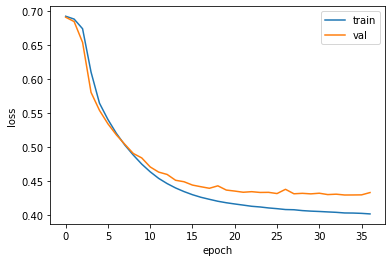

In [8]:
# 훈련/검증 손실 그래프로 확인
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#- 과대적합을 더 줄이기 위한 방법은? -드롭아웃

In [9]:
# RNN에 드롭아웃 적용하기
#- 드롭아웃은 과대적합을 막기 위해 사용한다!
#- RNN 은 자체적으로 드롭아웃 기능을 제공한다.
#- SimpleRNN(), LSTM()은 매개변수로 dropout, recurrent_dropout 을 가지고 있다.
#-- dropout 매개변수: 셀의 입력에 드롭아웃 적용
#-- recurrent_dropout 매개변수: 순환되는 은닉상태에 드롭아웃 적용 (기술적인 문제로 GPU를 사용하여 모델 훈련 못함!!)

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))   # 드롭아웃 비중 30%
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [10]:
# 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 47ms/step - loss: 0.6926 - accuracy: 0.5494 - val_loss: 0.6921 - val_accuracy: 0.5728
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6907 - accuracy: 0.6157 - val_loss: 0.6892 - val_accuracy: 0.6542
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6831 - accuracy: 0.6507 - val_loss: 0.6683 - val_accuracy: 0.6280
Epoch 4/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6379 - accuracy: 0.6951 - val_loss: 0.6145 - val_accuracy: 0.7148
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6088 - accuracy: 0.7164 - val_loss: 0.5948 - val_accuracy: 0.7284
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 0.5911 - accuracy: 0.7296 - val_loss: 0.5780 - val_accuracy: 0.7374
Epoch 7/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5736 - accuracy: 0.7372 - val_loss: 0.5618 - val_ac

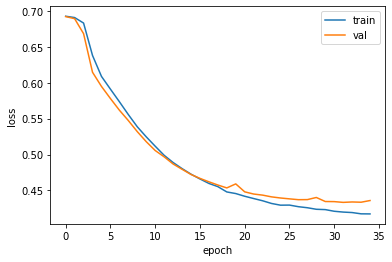

In [11]:
# 훈련/검증 손실 그래프로 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#- val_loss 가 개선됨

In [3]:
# 2개의 층을 연결하기
#- 주의: 순환층의 은닉상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달한다.
#-- 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하다.
#--- 따라서 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.
#--- 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야 한다.

# RNN 에서 모든 타임스텝의 은닉 상태를 출력 - return_sequences=True 매개면수 추가
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
#- 모든 타임스텝(100개)의 은닉 상태를 출력 (100, 8)
model3.add(keras.layers.LSTM(8, dropout=0.3))
#- 마지막 타임스텝의 은닉 상태만 출력 (8)
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 21s 45ms/step - loss: 0.6924 - accuracy: 0.5540 - val_loss: 0.6913 - val_accuracy: 0.6012
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6875 - accuracy: 0.6204 - val_loss: 0.6805 - val_accuracy: 0.6600
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6572 - accuracy: 0.6604 - val_loss: 0.6188 - val_accuracy: 0.6896
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5792 - accuracy: 0.7034 - val_loss: 0.5444 - val_accuracy: 0.7302
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5330 - accuracy: 0.7376 - val_loss: 0.5147 - val_accuracy: 0.7484
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5119 - accuracy: 0.7539 - val_loss: 0.4961 - val_accuracy: 0.7620
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4981 - accuracy: 0.7646 - val_loss: 0.4853 - val_ac

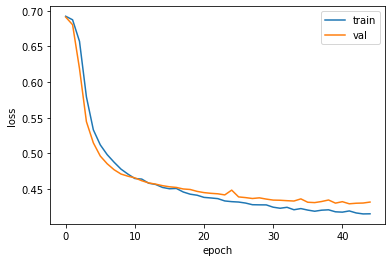

In [6]:
# 일반적으로 RNN을 쌓으면 성능이 높아진다고 한다.
# 이 예에서는 그리 큰 효과를 내지 못한거라고 한다.

# 손실 그래프로 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [7]:
# GRU -----------------------------

model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
#- 800 = 500 * 16
model4.add(keras.layers.GRU(8))
#- 624 = ((16(앞출력의입력) * 8(노드))(입력에 곱하는 가중치) + (8 * 8)(은닉에 곱하는 가중치) + (8*3)(절편)) * 3(GRU 셀 3개)
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 학습
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 0.6923 - accuracy: 0.5314 - val_loss: 0.6915 - val_accuracy: 0.5598
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6906 - accuracy: 0.5655 - val_loss: 0.6895 - val_accuracy: 0.5814
Epoch 3/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6878 - accuracy: 0.5932 - val_loss: 0.6863 - val_accuracy: 0.5888
Epoch 4/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6834 - accuracy: 0.6076 - val_loss: 0.6812 - val_accuracy: 0.6076
Epoch 5/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6765 - accuracy: 0.6192 - val_loss: 0.6736 - val_accuracy: 0.6150
Epoch 6/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6661 - accuracy: 0.6348 - val_loss: 0.6619 - val_accuracy: 0.6256
Epoch 7/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6508 - accuracy: 0.6469 - val_loss: 0.6449 - val_accuracy:

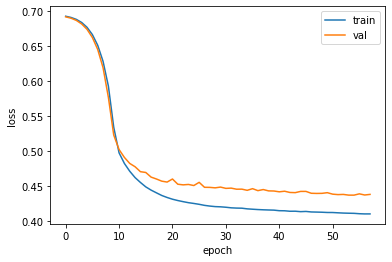

In [9]:
# 결과 손실 그래프 확인
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#- 드롭아웃을 쓰면 valid 가 더 효과적일 것이다.

In [10]:
# 위 과정중에 가장 성능이 좋았던 2 RNN 의 평가
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 13s 16ms/step - loss: 0.4261 - accuracy: 0.7998


[0.4260537624359131, 0.7997999787330627]